# 2 Geodata

`location` kolonnen kommer fra google maps og indeholder koordinat og zoom level.

Vi skal have oversat til noget vi kan bruge i vores kort.

Det bliver til `geometry` kolonnen i WKT format.

Vi bruger `geopandas` til at gøre datasættet geografisk.

Der er 2 plot i denne notebook:
1. `plot` er et plot af alle punkterne i datasættet, med Peter Mærsk.
2. `plot2` er et plot af alle breve, hvor vi har tegnet linjer mellem punkter. Her er det kun breve fra Peter Mærsk, da det er ham, vi gerne vil følge

In [12]:
# load jsonfile from disk
import json
import pandas as pd
import geopandas as gpd
import contextily as cx
from matplotlib import pyplot as plt
from shapely import wkt
from shapely.geometry import Point, Polygon


In [13]:
df = pd.read_csv('../data/letters.csv')	

In [14]:
# print number of letters without location
print("Number of letters without location: ", df["location"].isnull().sum())

df.dropna(subset=['location'], inplace=True)

# parse into geopandas
df["geometry"] = df["location"].str.split(",")

df['geometry'] = df['geometry'].apply(lambda x: x[:-1])

# convert geometry to wkt from [lat,lon] to POINT(lon lat)
df['geometry'] = df['geometry'].apply(lambda x: 'POINT (' + x[1] + ' ' + x[0] + ')')
# geometry to geometry object

df['geometry'] = df['geometry'].apply(wkt.loads)

# convert to geodataframe
gdf = gpd.GeoDataFrame(df, geometry='geometry')


Number of letters without location:  28


In [15]:
# historical background map
gdf1914world = gpd.read_file('../maps/1914/1914.geojson')


In [16]:

capitals = gpd.read_file('../maps/capitals.geojson', encoding='utf-8', engine='pyogrio')


In [17]:
# remove the world outside 
ylim=(43,60)
xlim=(-3,40)

# remove countries outside the map
gdf1914 = gdf1914world.cx[xlim[0]:xlim[1], ylim[0]:ylim[1]]

In [18]:
danish_countries = [
    'Belgien', 'Bulgarien', 'Schweiz', 'Danmark', 'Finland', 'Frankrig', 
    'Guernsey', 'Italien', 'Jersey', 'Liechtenstein', 'Luxembourg', 
    'Montenegro', 'Nederlandene', 'Norge', 'San Marino', 'Serbien', 
    'Sverige', 'Rumænien', 'Østrig-Ungarn', 'Storbritannien', 
    'Tyskland', 'Den Russiske Føderation', 'Monaco', 'Spanien'
]

# English names of the countries
english_countries = [
    'Belgium', 'Bulgaria', 'Switzerland', 'Denmark', 'Finland', 'France', 
    'Guernsey', 'Italy', 'Jersey', 'Liechtenstein', 'Luxembourg', 
    'Montenegro', 'Netherlands', 'Norway', 'San Marino', 'Serbia', 
    'Sweden', 'Rumania', 'Austria - Hungary ', 'United Kingdom', 
    'Germany', 'Russian Federation', 'Monaco', 'Spain'
]

# Function to replace English country names with Danish names in a GeoPandas DataFrame
def replace_country_names(df, column_name='NAME'):
    """
    Replace country names in a specified column of a GeoPandas DataFrame with their Danish equivalents.

    Args:
    df (GeoDataFrame): The GeoPandas DataFrame containing country names.
    column_name (str): The name of the column in the DataFrame that contains country names. Default is 'NAME'.

    Returns:
    GeoDataFrame: The DataFrame with country names replaced.
    """
    translation_map = dict(zip(english_countries, danish_countries))
    df[column_name] = df[column_name].map(translation_map).fillna(df[column_name])
    #return df

replace_country_names(gdf1914, 'NAME')

c:\Users\christian.dalager\AppData\Local\anaconda3\envs\jernkors\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


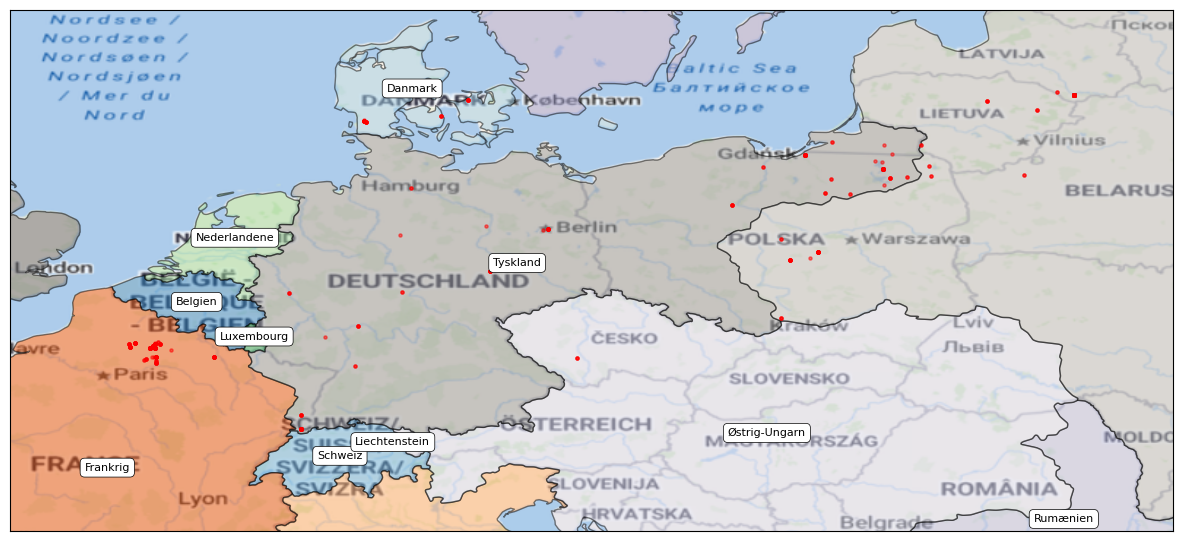

In [27]:
fig, ax = plt.subplots(figsize=(15, 15))


ax.axis((0, 29, 45, 58))

gdf1914.plot(ax=ax, cmap="tab20c", edgecolor="black", alpha=0.5)
gdf1914.apply(
    lambda x: ax.annotate(
        x.NAME, xy=x.geometry.centroid.coords[0], ha="center", size=8,
                    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5), 

    ),
    
    axis=1,
)
ax.annotate("Rusland", xy=(30, 55), ha="center", size=8,
                    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5),)
gdf.plot(ax=ax, edgecolor="red", markersize=5, alpha=0.5, color="red")
apitoken = '10684642-480c-4a16-8eb9-243e699b69ac'
cx.add_basemap(ax, crs='EPSG:4326', source='https://tiles.stadiamaps.com/tiles/outdoors/{z}/{x}/{y}{r}.png?api_key='+apitoken)

ax.set_xticks([])
ax.set_yticks([])
plt.savefig("images/letters.png", dpi=300, bbox_inches="tight")

638


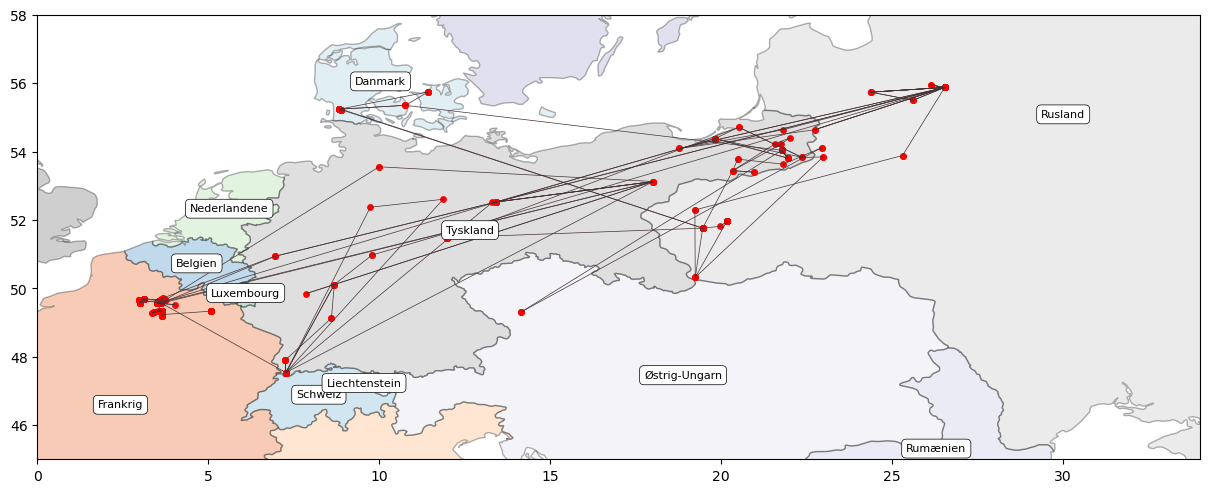

In [20]:
# create a line between the points of the letters
# sender must be "Peter Mærsk"
gdf = gpd.GeoDataFrame(df, geometry='geometry')
print(len(gdf))
gdf = gdf[gdf['sender'] == 'Peter Mærsk']
gdf = gdf.sort_values(by='id')

# only the first 100 letters
# gdf = gdf[500:]

points = gdf.geometry.tolist()
from shapely.geometry import LineString
# Create line strings between each point
lines = [LineString([points[i], points[i + 1]]) for i in range(len(points) - 1)]

# Create a new GeoDataFrame for lines
line_gdf = gpd.GeoDataFrame(geometry=lines)

# Plotting (optional)
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_ylim(45,58)
ax.set_xlim(0,34)


#cx.add_basemap(ax, crs='epsg:4326',source=cx.providers.CartoDB.Voyager)
gdf1914.plot(ax=ax, cmap="tab20c", edgecolor='black',alpha=0.3)
line_gdf.plot(ax=ax, linewidth=0.5, color='#443234')  # Plot lines

gdf1914.apply(lambda x: ax.annotate(x.NAME, xy=x.geometry.centroid.coords[0], ha='center', size=8,bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5)),axis=1)
ax.annotate('Rusland', xy=(30, 55), ha='center', size=8,bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5))
gdf.plot(ax=ax,marker='o', color='red', markersize=15, alpha=1)  # Plot points

plt.savefig('images/letters_connected.png', dpi=300, bbox_inches='tight')


# create a line between the points of the letters


In [21]:
## THIS DOES NOT BELONG HER
# for each letter we calculate the time between the letters
from datetime import datetime
dates = gdf['date'].tolist()
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

# calculate the time between the letters
from datetime import timedelta
time_between = [0.0]
for i in range(len(dates) - 1):
    time_between.append((dates[i + 1] - dates[i]).days)

gdf["days_from_last"] = time_between

602
602


<Axes: title={'center': 'Days between letters'}>

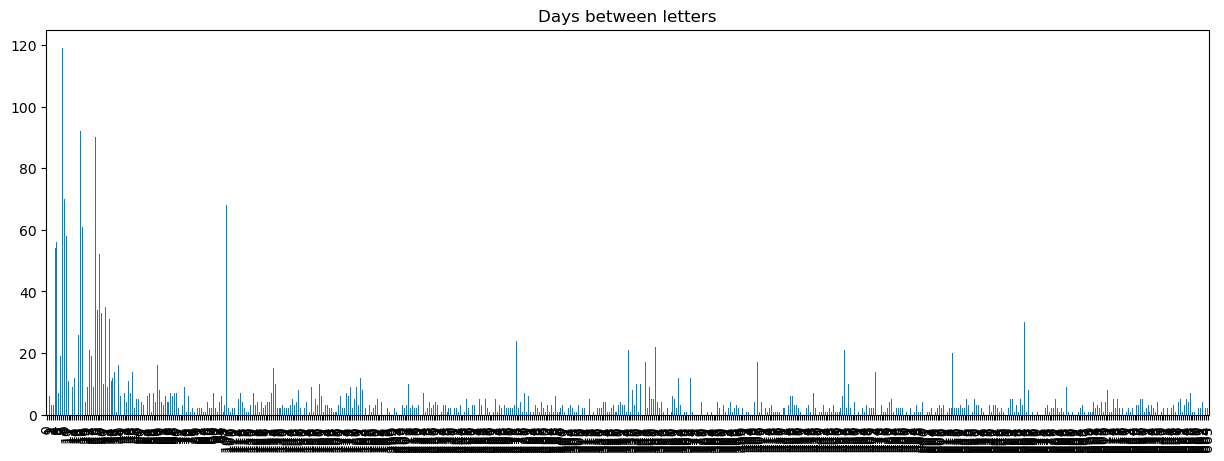

In [22]:
points = gdf.geometry.tolist()
points

# for each point in the list we calculate the distance to the previous point in kms
from geopy.distance import geodesic
distances = [0.0]
for i in range(len(points) - 1):
    distances.append(geodesic(points[i].coords[0], points[i + 1].coords[0]).km)
distances
print(len(distances))
print(len(gdf))

# add the distances to the dataframe
gdf['km_from_last'] = distances


# calculate the total distance from the first letter
gdf['km_from_start'] = gdf['km_from_last'].cumsum()


# calculate the km/hour between the letters and use 0 if the time is 0
gdf['km_per_hour'] = gdf['km_from_last'] / gdf['days_from_last'].replace(0, 1)

# the 10 fastest letters
#gdf = gdf.sort_values(by='km_per_hour', ascending=False)

# sort by date asc
gdf = gdf.sort_values(by='date')

#gdf.km_from_last.plot(kind='bar', figsize=(15, 5), title='Distance from last letter (km)')

# plot time between letters
gdf.days_from_last.plot(kind='bar', figsize=(15, 5), title='Days between letters')


#gdf









In [23]:
# distinct names
#gdf1914.NAME.unique()

In [24]:
# mapping ids to countries
mapping = [(70,'Frankrig')]


# plot the shapefile
#fig, ax = plt.subplots(figsize=(15, 15))
#shapefile.plot(ax=ax, color='white', edgecolor='black',linewidth=0.5, alpha=0.5)

shp = shapefile#[shapefile.SUBREGION == '0']

fig, ax = plt.subplots(1,2,figsize=(15, 15))
# add blue background 
#ax.set_facecolor('lightgrey')
bbox = gdf.bounds

# simplify the geometry
#shpdf['geometry'] = shpdf['geometry'].simplify(0.2, preserve_topology=True)

shpdf.plot(ax=ax[0], colormap='tab20c',column="COUNTRY", edgecolor='black',linewidth=0.5, alpha=0.5)
gdf.plot(ax=ax[0], edgecolor='red',markersize=2,  alpha=0.5, color='red')
ax[0].set_ylim(bbox.miny.min()-10, bbox.maxy.max()+10)
ax[0].set_xlim(bbox.minx.min()-10, bbox.maxx.max()+10)
ax[0].set_title('1900 - Census Mosaic')


#gdf1914.plot(ax=ax, colormap='tab20c',column="NAME", edgecolor='black',linewidth=0.5, alpha=0.5)
# country labels from gdff
gdf1914.apply(lambda x: ax.annotate(x.NAME, xy=x.geometry.centroid.coords[0], ha='center', size=8),axis=1)
gdf1914.plot(ax=ax[1], colormap='tab20c',column="NAME", edgecolor='black',linewidth=0.5, alpha=0.5)
gdf.plot(ax=ax[1], edgecolor='red',markersize=2,  alpha=0.5, color='red')
ax[1].set_ylim(bbox.miny.min()-10, bbox.maxy.max()+10)
ax[1].set_xlim(bbox.minx.min()-10, bbox.maxx.max()+10)
ax[1].set_title('1914 - Historical Boundaries')

# save figure
plt.savefig('images/letters_1900_1914.png', dpi=300, bbox_inches='tight')



NameError: name 'shapefile' is not defined